# Imports

In [12]:
# ignore deprecation warnings ('safe' as long as we don't update packages)
from warnings import filterwarnings
filterwarnings("ignore")

from math import sqrt, log, inf
import copy

import gym
from gym_go.gogame import turn, random_weighted_action, random_action

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


# Constants

In [14]:
UCB_C = 2

# Board will be a BOARD_SIZE * BOARD_SIZE board (BOARD_SIZE**2)
BOARD_SIZE = 5
ACTIONSPACE_LENGTH = BOARD_SIZE ** 2 + 1
'''
The state object that is returned by the reset and step functions of the environment is a
6 x BOARD_SIZE x BOARD_SIZE numpy array. All values in the array are either 0 or 1.
'''

# 0 - Black pieces
# 1 - White pieces
# 2 - Turn (0 - black, 1 - white)
# 3 - Invalid moves (including ko-protection)
# 4 - Previous move was a pass
# 5 - Game over
BLACK, WHITE, INVALID = 0, 1, 3

# Monte Carlo Tree Search

1. Selection
    - Taverse the tree to find greatest UCB-score
2. Expansion
    - If the selected leaf node has been visited before expand by adding weighted game action
3. Rollout
    - Simulate the game until end-condition from the expanded leaf
4. Back-propagation
    - Updating the value of each ancestor node of the expanded leaf


In [15]:
class Node():
    def __init__(self, env, parent, action):
        self.env : gym.Env = env # This env will be altered by the other player
        self.value : int = 0 # Value estimate
        self.trials : int = 0 # Number of trials for this node
        self.parent : Node = parent # Parent node of this node
        self.children : list[Node] = [] # List of children of this node
        self.action : int = action # The step action made by this node
    
    # calculate a Upper Confidence Bound
    def ucb(self, total_trials):
        return self.value + ( UCB_C * sqrt(log(total_trials) / self.trials) )
    
    # Add a new node to a leaf node
    def expansion(self):
        for action in range(ACTIONSPACE_LENGTH - 1):
            x, y = action // BOARD_SIZE, action % BOARD_SIZE
            if self.env.state()[INVALID, x, y] == 0:
                child_env = copy.deepcopy(self.env)
                child_env.step(action)
                self.children.append(Node(child_env, self, action))

        child_env = copy.deepcopy(self.env)
        child_env.step(ACTIONSPACE_LENGTH - 1)       
        self.children.append(Node(child_env, self, ACTIONSPACE_LENGTH - 1))

    # Simulate game from current move until end-condition returning the score
    def rollout(self, move_selection_method):
        if self.env.done:
            return self.env.reward()
        
        rollout_env = copy.deepcopy(self.env)
        rollout_result = 0
        done = False
        while not done:
            random_action = move_selection_method(rollout_env)
            _, reward, done, _ = rollout_env.step(random_action)
            rollout_result += reward
        return rollout_result

In [16]:
class Monte_Carlo_Tree_Search():
    def __init__(self, size, ml_model):
        self.env : gym.Env = gym.make('gym_go:go-v0', size=size, reward_method='heuristic')
        self.env.reset()
        self.root = Node(self.env, None, None)
        self.ml_model = ml_model
        if ml_model is not None:
            ml_model.to(device)
    
    # Gets the weights of all moves from the Machine Learning model
    def __get_move_weights(self, env : gym.Env):
        state = env.state()
        if self.ml_model is not None:
            move_weights = self.ml_model.forward(torch.tensor(state, device=device)).cpu().detach().numpy()
        else:
            move_weights = np.ones(ACTIONSPACE_LENGTH)

        board_shape = state.shape[1:]
        for i in range(len(move_weights) - 1):
            action2d = i // board_shape[0], i % board_shape[1], i
            if state[INVALID, action2d[0], action2d[1]] == 1:
                move_weights[i] = 0.0
        return move_weights

    # Gets a weighted move for the given env
    def get_weighted_move(self, env : gym.Env):
        move_weights = self.__get_move_weights(env)
        return random_weighted_action(move_weights)

    # Update scores of all parent nodes after rollout
    def __back_propagation(self, rollout_node: Node, rollout_result):
        current_node = rollout_node
        while current_node != None:
            current_node.trials += 1
            if turn(self.env.state()) == BLACK:
                current_node.value -= rollout_result
            if turn(self.env.state()) == WHITE:                
                current_node.value += rollout_result
            current_node = current_node.parent
    
    # Find and return the leaf node with the highest UCB-score 
    def __selection(self, node: Node = None):
        if node is None:
            node = self.root
        selected_child = node
        current_node = node
        while len(current_node.children) > 0:
            current_best_ucb = -inf
            for child in current_node.children:
                if child.trials == 0:
                    return child

                child_ucb = child.ucb(self.root.trials)

                if child_ucb > current_best_ucb:
                    selected_child = child
                    current_best_ucb = child_ucb

            current_node = selected_child

        return selected_child
    
    # Explores the tree for the given number of iterations
    def run(self, iterations, node: Node = None):
        if node is None:
            node = self.root

        selected_node = node
        run = 0
        while run < iterations:
            selected_node = self.__selection(node)

            if not selected_node.env.done and selected_node.trials > 0:
                selected_node.expansion()
                selected_node = selected_node.children[0]

            rollout_result = selected_node.rollout(self.get_weighted_move)
            
            self.__back_propagation(selected_node, rollout_result)
            run += 1

    # Explores plays one game
    def run_game(self):
        # Run MCTS until a game is completed
        selected_node = self.root
        run = 1
        while not selected_node.env.done:
            # print("run:", run)
            selected_node = self.__selection()

            if selected_node.trials > 0:
                # print("Expanding node")
                selected_node.expansion()
                selected_node = selected_node.children[0]

            # print("Rollout")
            rollout_result = selected_node.rollout(self.get_weighted_move)
            self.__back_propagation(selected_node, rollout_result)
            # print("Done:", selected_node.env.done)
            run += 1
        # returns the node to allow for printing the game
        return selected_node
    
    # searches the tree for a spesific state
    def __find_node_from_state(self, state, node: Node = None):
        if node is None:
            node = self.root
        if np.array_equal(node.env.state(), state):
            return node

        for child in node.children:
            if np.array_equal(child.env.state(), state):
                return child
            
            res = self.__find_node_from_state(state, child)
            if res != None and np.array_equal(res.env.state(), state):
                return res

    # Attempts to find the best move from the tree by searching for the state and finding the best child for that state
    def get_move_from_env(self, env):
        node = self.__find_node_from_state(env.state())

        while node is None:
            self.run(15)
            node = self.__find_node_from_state(env.state())

        self.run(15, node)

        best_child = None
        current_best_value = -inf
        for child in node.children:
            if child.value > current_best_value:
                best_child = child
                current_best_value = child.value

        if best_child != None:
            if len(best_child.children) == 0 and not best_child.env.done:
                best_child.expansion()
            return best_child

    # Makes a list of all states and a list of all move_weights for all expanded nodes in the tree
    def get_tree_data(self):
        x, y = [], []
        self.__get_node_data(self.root, x, y)
        return torch.tensor(x), torch.tensor(y)

    # recurrsive tree traversal method for get_tree_data
    def __get_node_data(self, node, x, y):
        x.append(node.env.state())
        y.append([0] * (BOARD_SIZE**2 + 1))
        for child in node.children:
            y[-1][child.action] = child.value
            if len(child.children) > 0:
                self.__get_node_data(child, x, y)

In [17]:
def play_game_no_render(mcts : Monte_Carlo_Tree_Search, go_env: gym.Env):
    go_env.reset()
    done = go_env.done
    turn_nr = 0
    while not done:
        action = random_action(go_env.state())
        _, _, done, _ = go_env.step(action)

        if done:
            continue

        node = mcts.get_move_from_env(go_env)
        _, _, done, _ = go_env.step(node.action)
        turn_nr += 1
        if turn_nr > 300:
            break
    
    return go_env

In [18]:
mcts_test = Monte_Carlo_Tree_Search(BOARD_SIZE, None)
_ = mcts_test.run_game()

In [19]:
for i in range(10):
    env = play_game_no_render(mcts_test, copy.deepcopy(mcts_test.env))
    if not env.done:
        print("Game stopped after 300 turns: \nIt was resigned and is a draw.")
        continue
        
    if env.reward() < 0:
        print("White won!")
    if env.reward() > 0:
        print("Black won!")
    if env.reward() == 0:
        print("It's a draw!")

White won!
White won!
Black won!
White won!
Black won!
White won!
White won!
White won!
White won!
White won!


# Convolutional Neural Network

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128, 26)

    def forward(self, x):
        x = x.float()
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 0, -1)
        x = F.softmax(self.fc1(x))
        return x

    def avg_accuracy(self, x, y):
        avg = 0
        for i in range(len(x)):
            avg += torch.mean(torch.eq(self.forward(x[i]).argmax(), y[i].argmax()).float())
        return (avg/len(x))

In [21]:
# utility methods for importing and exporting models, defined outside class
def export_model(cnn, name="cnn"):
    torch.save(cnn.state_dict(), "cnns/" + name + ".pth")

def import_model(cnn, name="cnn"):
    cnn.load_state_dict(torch.load("cnns/" + name + ".pth"))

In [22]:
def train_model(model, lr, momentum):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model.to(device)
    for epoch in range(10):
        mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, model) # new tree
        mcts.run_game() # run a single game to completion
        x, y = mcts.get_tree_data() # get data
        running_loss = .0 
        for i in range(len(x)):
            inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
            labels = F.softmax(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 10 == 9:
                print(f'[{epoch:3d}, {i + 1:3d}] loss: {running_loss / 10:.5f}')
                running_loss = 0.0

import time

def train(n_games=1000):
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Stats
    all_x, all_y, loss_values, acc_values = [], [], [], []
    total_time = 0

    # Simulate N games
    for _ in range(n_games):

        # Run a simulation and time it for statistics
        mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, model)
        start = time.time()
        mcts.run_game()
        stop = time.time()
        total_time += (stop - start)

        game_loss = .0

        # Train model on data
        x, y = mcts.get_tree_data()
        for i in range(len(x)):
            inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
            labels = F.softmax(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            game_loss += loss.item()
            
            # Add data to master list for accuracy calculation
            all_x.append(x[i])
            all_y.append(y[i])
        
        # After training, check accuracy against previous data
        acc_values.append(model.avg_accuracy(all_x, all_y).item())
        loss_values.append(game_loss/len(x))

    print(f'''Finished running {n_games} games
    Time..............: {total_time}
    Avg. time per game: {total_time/n_games}''')
    return model, loss_values, acc_values


In [23]:
model, loss_values, acc_values = train(5)

Finished running 5 games
    Time..............: 101.08471536636353
    Avg. time per game: 20.216943073272706


[3.258183387203823, 3.257353039377346, 3.2553978168084465, 3.257621145147345, 3.257438591855839]
[0.03125, 0.1666666716337204, 0.16853933036327362, 0.19745223224163055, 0.1913580298423767]


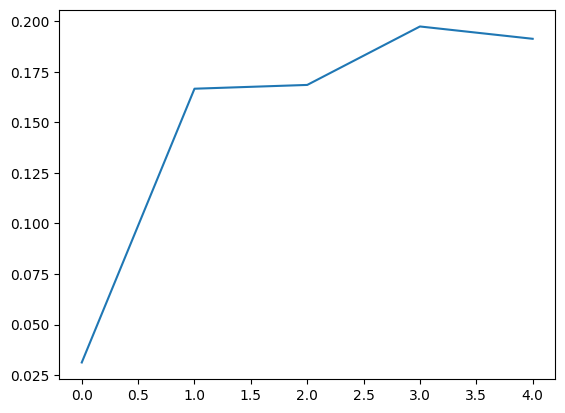

In [24]:
print(loss_values)
print(acc_values)

# plt.plot(loss_values)
plt.plot(acc_values)

# MCTS and CNN combined

1. Create an MCTS
2. Generate a lot of data from the MCTS
3. Use the data to train a CNN
4. Use the CNN in a new MCTS to hopefully make the MCTS make better choices
5. Generate new data with the new MCTS
6. Train a new CNN... repeat ad infinitum

In [25]:
cnn = CNN()
# mcts = Monte_Carlo_Tree_Search(BOARD_SIZE, None)
# mcts.run(1000)
# x, y = mcts.get_tree_data()
# print("Datapoints: ", len(x))
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
# cnn.to(device)
# for i in range(len(x)):
#     inputs, labels = torch.tensor(x[i], device=device), torch.tensor(y[i], device=device)
#     labels = F.softmax(labels)
#     optimizer.zero_grad()
#     outputs = cnn(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

# train_model(cnn, .01, .9)